In [759]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import os

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Cumulative Enrollment

In [760]:
cumulative_enrollment_path = os.path.join('Datasets', 'cumulative_enrollment.csv')
cumulative_enrollment = pd.read_csv(cumulative_enrollment_path, low_memory=False)
#Removed insignificant columns
#Changed all * values (missing for student privacy) to NaN, rest of CumulativeEnrollment to float.
cumulative_clean = cumulative_enrollment.drop(["AcademicYear", "CountyCode", "DistrictCode", "SchoolCode"], axis=1) #Dropped codes
cumulative_clean["CumulativeEnrollment"] = pd.to_numeric(cumulative_clean["CumulativeEnrollment"], errors='coerce')

In [761]:
cumulative_clean["School, District"] = cumulative_clean["SchoolName"] + ", " + cumulative_clean["DistrictName"]
cumulative_clean = cumulative_clean[cumulative_clean["AggregateLevel"] == "S"]
cumulative_clean = cumulative_clean[cumulative_clean["CountyName"] == "San Diego"]
cumulative_clean = cumulative_clean.rename(columns={'SchoolName': "School"})
cumulative_clean = cumulative_clean[cumulative_clean["Charter"] == "No "]
cumulative_clean = cumulative_clean.drop(["Charter"], axis=1)

latino = cumulative_clean.copy(deep=True)

cumulative_clean = cumulative_clean[cumulative_clean["ReportingCategory"] == "TA"]
# Made a seperate col for the hispanic population % of that school
latino = latino[latino["ReportingCategory"] == "RH"]
latino = latino[["ReportingCategory", "CumulativeEnrollment", "School, District"]]
latino_enrollment = cumulative_clean.merge(latino, on="School, District")
latino_enrollment["Latino%"] = latino_enrollment["CumulativeEnrollment_y"] / latino_enrollment["CumulativeEnrollment_x"]
latino_enrollment = latino_enrollment.drop(columns=["ReportingCategory_x", "ReportingCategory_y", "CumulativeEnrollment_y"])
latino_enrollment = latino_enrollment.rename(columns={"CumulativeEnrollment_x": "CumulativeEnrollment"})
cumulative_clean = latino_enrollment

### Public Schools

In [762]:
schools = pd.read_csv('Datasets/pubschools_info.csv')

schools = schools.loc[schools['County'] == 'San Diego']
# Dropped uncessary cols
cols_to_drop = ["NCESDist","NCESSchool","StreetAbr","MailStreet","MailStrAbr","MailCity",
               "MailZip","MailState","Ext","FaxNumber","Email","Phone","CharterNum",
                "FundingType","DOC","DOCType","EdOpsCode","EdOpsName","Magnet","FederalDFCDistrictID",
                "AdmFName","AdmLName","AdmEmail","YearRoundYN",'State', 
                'OpenDate',"SOC", "SOCType","GSoffered","GSserved",'ClosedDate']

schools = schools.drop(cols_to_drop, axis=1)

C:\Users\Andrew Chin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [763]:
clean1 = schools.loc[schools['StatusType'] == 'Active'] #Keeps only active schools
clean3 = clean1.loc[clean1['School'] != 'No Data'] #drops district records - nonschools
clean3['LastUpDate'] = pd.to_datetime(clean3['LastUpDate']) #change lastUpDate to datetime obj col
clean3 = clean3.reset_index().drop('index',axis = 1)
schools = clean3

schools = schools.replace("No Data",np.nan) #changed "No Data" into NaNs
schools['Latitude'] = schools['Latitude'].astype(float) #changed latitutde to float dtype
schools['Longitude'] = schools['Longitude'].astype(float) #changed longitude to float dtype
schools = schools.drop(['StatusType','County'],axis = 1) #dropped statustype and county col since its all active and SD county

# small_zip = schools['Zip'].str.slice(0,5).astype(float)
# schools = schools.assign(SmallZip=small_zip)

C:\Users\Andrew Chin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [764]:
# Added an address col made up of the street, city,state and zip cols
address = schools['Street'] + ',' + schools['City'] + ",CA," + schools['Zip'].str.slice(0,5)
schools = schools.assign(Address = address).drop(["Street",'City'],axis = 1)
schools = schools.assign(Zipcode = schools['Zip'].str.slice(0,5))
schools['Zipcode'] = schools['Zipcode'].astype(int)

In [765]:
schools = schools.drop(columns=["Virtual"], axis=1)

In [766]:
type_of_schools = ['ELEM','HS','INTMIDJR','ELEMHIGH']
schools = schools[schools.EILCode.isin(type_of_schools)]
# Kept only non-charter schools
schools = schools.loc[schools['Charter'] == 'N']
schools = schools.drop(['EILCode','Charter'],axis = 1)

In [767]:
# Combined school name and district name to form a col where we can merge for the cumulative enrollment dataset
schools["School, District"] = schools["School"] + ", " + schools["District"]

In [768]:
schools.head(3)

,CDSCode,District,School,Zip,WebSite,EILName,Latitude,Longitude,LastUpDate,Address,Zipcode,"School, District"
1,37103710115998,San Diego County Office of Education,San Pasqual Academy,92025-5301,http://www.sanpasqualacademy.org,High School,33.090580,-116.95009,2019-02-13,"17701 San Pasqual Valley Road,Escondido,CA,92025",92025,"San Pasqual Academy, San Diego County Office o..."
2,37103710120485,San Diego County Office of Education,Davila Day,91910-3604,NaN,Elementary,32.635041,-117.08832,2019-02-13,"540 G Street,Chula Vista,CA,91910",91910,"Davila Day, San Diego County Office of Education"
3,37103710120493,San Diego County Office of Education,Monarch,92113-1012,http://www.monarchschools.org,Elementary-High Combination,32.702375,-117.15045,2020-08-24,"1625 Newton Avenue,San Diego,CA,92113",92113,"Monarch, San Diego County Office of Education"


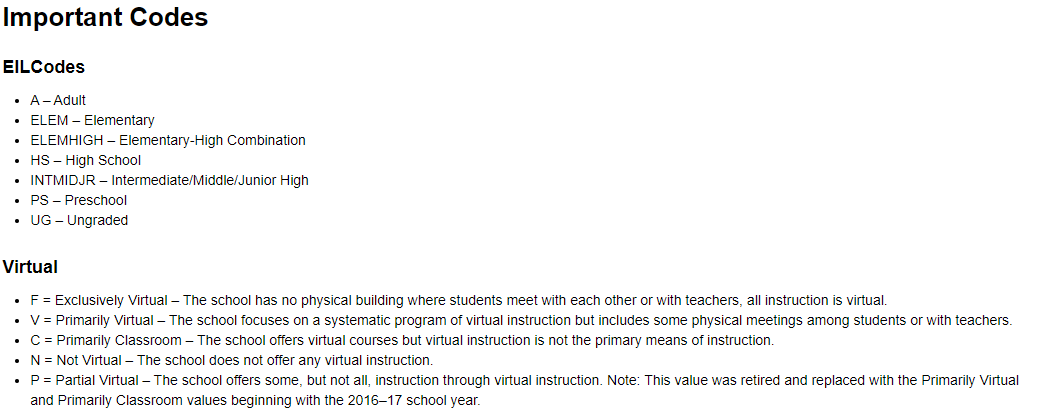

### Incomes

In [769]:
incomes_path = os.path.join('Datasets', 'suave_income.csv')
incomes = pd.read_csv(incomes_path, low_memory=False)

In [770]:
incomes_classes = incomes[["ZIP", 
         "Hholds with income Less than $10,000#number", 
         'Hholds with income $10,000 to $14,999#number',
         'Hholds with income $15,000 to $24,999#number',
         'Hholds with income $25,000 to $34,999#number',
         'Hholds with income $35,000 to $49,999#number',
         'Hholds with income $50,000 to $74,999#number',
         'Hholds with income $75,000 to $99,999#number',
         'Hholds with income $100,000 to $149,999#number',
         'Hholds with income $150,000 to $199,999#number',
         'Hholds with income $200,000 or more#number',
         'Median family income (dollars)#number',
         'Mean family income (dollars)#number',
         'Health insurance coverage, % of civilian pop#number',
         'No health insurance for civil pop#number',
         'No health insurance coverage, %#number',
         'Worked at home#number', 'Population 16+yo#number', 'Children of the hh 6-17 yo#number'
         ]]
incomes_clean = incomes_classes.copy()
# Seperated the income levels to 3 levels: 0-35k , 35-100, and 100 +
incomes_clean["Households with income $0-34,999"] = (incomes_classes["Hholds with income Less than $10,000#number"] 
                                               + incomes_classes["Hholds with income $10,000 to $14,999#number"] 
                                               + incomes_classes["Hholds with income $15,000 to $24,999#number"] 
                                               + incomes_classes["Hholds with income $25,000 to $34,999#number"]
                                              )
incomes_clean["Households with income $35,000-99,999"] = (incomes_classes["Hholds with income $35,000 to $49,999#number"] 
                                               + incomes_classes["Hholds with income $50,000 to $74,999#number"] 
                                               + incomes_classes["Hholds with income $75,000 to $99,999#number"] 
                                              )
incomes_clean["Households with income $100,000+"] = (incomes_classes["Hholds with income $100,000 to $149,999#number"] 
                                               + incomes_classes["Hholds with income $150,000 to $199,999#number"]
                                               + incomes_classes["Hholds with income $200,000 or more#number"] 
                                              ) 
incomes_clean = incomes_clean.drop(["Hholds with income Less than $10,000#number", 
         'Hholds with income $10,000 to $14,999#number',
         'Hholds with income $15,000 to $24,999#number',
         'Hholds with income $25,000 to $34,999#number',
         'Hholds with income $35,000 to $49,999#number',
         'Hholds with income $50,000 to $74,999#number',
         'Hholds with income $75,000 to $99,999#number',
         'Hholds with income $100,000 to $149,999#number',
         'Hholds with income $150,000 to $199,999#number',
         'Hholds with income $200,000 or more#number',], axis=1)
incomes_clean = incomes_clean.rename(columns={'Median family income (dollars)#number': 'Median family income (dollars)',
                                             'Mean family income (dollars)#number' :'Mean family income (dollars)',
                                             'Health insurance coverage, % of civilian pop#number':'Health insurance coverage, % of civilian pop',
                                             'No health insurance for civil pop#number': 'No health insurance for civilian pop',
                                             'No health insurance coverage, %#number': 'No health insurance coverage %',
                                             'Worked at home#number': 'Worked at home',
                                             'ZIP': 'Zipcode', 'Population 16+yo#number':'Population 16+', 
                                             'Children of the hh 6-17 yo#number': 'Children of the household 6-17'})


In [771]:
pop = incomes_clean[["Zipcode", "Population 16+"]]

### Cleaned Cases by Zipcode

In [772]:
cleaned_cases_path = os.path.join('Datasets', 'Cleaned_Cases_by_Zipcode.csv')
cleaned_cases = pd.read_csv(cleaned_cases_path, low_memory=False)

In [773]:
# Took the sum of the most recent update date of the zipcode dataset for each zipcode
recents = cleaned_cases[cleaned_cases['updatedate'] == cleaned_cases['updatedate'].max()]
test = pd.DataFrame(recents.groupby('Zipcode')['case_count'].sum())
cases_by_zip = test.reset_index().rename({'case_count':'Cases'},axis = 1)
cases_by_zip.head(3)

,Zipcode,Cases
0,91901,96
1,91902,222
2,91905,7


### August Cases Increase

In [774]:
august_cases_path = os.path.join('Datasets', 'August_Case_Increase.csv')
august_cases = pd.read_csv(august_cases_path, low_memory=False)

In [775]:
august_cases = august_cases[["Zipcode", "Absolute Increase", "Percent Increase"]]

In [776]:
august_cases = august_cases.merge(pop, on="Zipcode")

In [777]:
# Standerdized the Abs Inc of cases by the population of 16 yr +
august_cases["Absolute Increase Standardized"] = august_cases["Absolute Increase"] / august_cases["Population 16+"]

In [778]:
august_cases = august_cases.drop(["Absolute Increase", "Population 16+"], axis=1)

In [779]:
august_cases.head(3)

,Zipcode,Percent Increase,Absolute Increase Standardized
0,91901,23.08,0.001211
1,91902,31.36,0.003275
2,91905,16.67,0.000711


### Population by Zip Code

In [780]:
pop_by_zip_path = os.path.join('Datasets', 'Population by ZipCode.csv')
pop_by_zip = pd.read_csv(pop_by_zip_path, low_memory = False)
pop_by_zip = pop_by_zip.drop(['Unnamed: 0'], axis = 1)

In [781]:
# Reduced the dataset to only the Zipcode and Pop cols
pop_by_zip = pop_by_zip.rename(columns = {'ZIP code':'Zipcode' })
pop_by_zip.head(3)

,Zipcode,Population
0,91901,17403
1,91902,17653
2,91905,1700


## Dataset Merging

In [782]:
zips = schools["Zipcode"].unique()

In [783]:
merged = schools.merge(cumulative_clean, on="School, District")

In [784]:
done = merged.merge(incomes_clean, on="Zipcode")

In [785]:
done = done.merge(august_cases, on="Zipcode")

In [786]:
done_shorter = done.drop(columns=["AggregateLevel", "CountyName", "CDSCode", 
                                  "Zip", "WebSite",
                                  "LastUpDate", "School_x", "School_y", "District"], axis=1)

In [787]:
#Impute value for median family income for zip 91905 with that of 91906
done_shorter.loc[319, "Median family income (dollars)"] = 60240.0

In [788]:
done_shorter = done_shorter.merge(cases_by_zip)

In [789]:
done_shorter = done_shorter.merge(pop_by_zip)

## Standardizing

In [790]:
# Standerdized most feature by population or population of a household (as of 2019 in SD County)
pop = done_shorter['Population']
household_pop = pop / 2.87

In [791]:
done_shorter = done_shorter.assign(WorkedAtHomeSTD=done_shorter['Worked at home'] / pop)

In [792]:
done_shorter = done_shorter.assign(HouseholdsIncome0kto35kSTD=done_shorter['Households with income $0-34,999'] / household_pop)

In [793]:
done_shorter = done_shorter.assign(HouseholdsIncome35kto100kSTD=done_shorter['Households with income $35,000-99,999'] / household_pop)

In [794]:
done_shorter = done_shorter.assign(HouseholdsIncome100kPlusSTD=done_shorter['Households with income $100,000+'] / household_pop)

In [795]:
done_shorter = done_shorter.assign(CasesSTD=done_shorter['Cases'] / pop)

In [796]:
# Filled missing values of latino percentages based on number of latino students reported in CumulativeEnrollment dataset (0)
done_shorter['Latino%'] = done_shorter['Latino%'].fillna(0)

## K-Means Clustering

In [797]:
from sklearn.cluster import KMeans
import sklearn.preprocessing as pp

In [798]:
# Numeric columns and associated transformers
num_feat = [
    'CumulativeEnrollment', 
    "Health insurance coverage, % of civilian pop", 
    "WorkedAtHomeSTD",
    'HouseholdsIncome0kto35kSTD',
    'HouseholdsIncome35kto100kSTD', 
    'HouseholdsIncome100kPlusSTD', 
    'CasesSTD',
    "Children of the household 6-17",
    "Absolute Increase Standardized",
    'Latino%'
]
num_transformer = Pipeline(steps=[
    ('scaler', pp.StandardScaler())   # z-scale
])

# Categorical columns and associated transformers
cat_feat = ['EILName', 'Zipcode']
cat_transformer = Pipeline(steps=[
    ('intenc', pp.OrdinalEncoder()),   # converts to int
    ('onehot', pp.OneHotEncoder())     # output from Ordinal becomes input to OneHot
])

# preprocessing pipeline (put them together)
preproc = ColumnTransformer(transformers=[('num', num_transformer, num_feat), ('cat', cat_transformer, cat_feat)])

pl = Pipeline(steps=[('preprocessor', preproc), ('kmeans', KMeans(n_clusters=3, n_init=1000))])

In [799]:
pl.fit(done_shorter)

C:\Users\Andrew Chin\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['CumulativeEnrollment', 'Health ...init=1000, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))])

In [800]:
predictions = pl.predict(done_shorter)

In [801]:
done_shorter["predictions"] = predictions

# Feature & Data Analysis

Printing the mean of various features (some used in the model, some not) for each school cluster.

In [802]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["CumulativeEnrollment"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["CumulativeEnrollment"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["CumulativeEnrollment"]))

0: 677.109022556391
1: 845.0923076923077
2: 749.0585585585585


In [803]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["Population 16+"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["Population 16+"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["Population 16+"]))

0: 32149.996240601504
1: 32871.692307692305
2: 48343.78828828829


In [804]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["Children of the household 6-17"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["Children of the household 6-17"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["Children of the household 6-17"]))

0: 4931.353383458647
1: 6863.507692307692
2: 9436.693693693695


In [805]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["No health insurance for civilian pop"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["No health insurance for civilian pop"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["No health insurance for civilian pop"]))

0: 3530.5789473684213
1: 1967.8461538461538
2: 9000.198198198199


In [806]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["Mean family income (dollars)"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["Mean family income (dollars)"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["Mean family income (dollars)"]))

0: 102848.21052631579
1: 162133.46923076923
2: 73937.12612612612


In [807]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["Worked at home"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["Worked at home"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["Worked at home"]))

0: 1277.733082706767
1: 1946.9615384615386
2: 1237.7117117117118


In [808]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["Households with income $0-34,999"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["Households with income $0-34,999"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["Households with income $0-34,999"]))

0: 3366.6954887218044
1: 1951.7230769230769
2: 5787.617117117117


In [809]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["Households with income $35,000-99,999"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["Households with income $35,000-99,999"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["Households with income $35,000-99,999"]))

0: 6198.375939849624
1: 4411.7307692307695
2: 8164.828828828829


In [810]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["Households with income $100,000+"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["Households with income $100,000+"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["Households with income $100,000+"]))

0: 4781.9473684210525
1: 8005.992307692308
2: 3921.5765765765764


In [811]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["Percent Increase"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["Percent Increase"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["Percent Increase"]))

0: 35.53116541353381
1: 25.478769230769235
2: 32.46058558558556


In [812]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["Absolute Increase Standardized"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["Absolute Increase Standardized"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["Absolute Increase Standardized"]))

0: 0.0025381574599974994
1: 0.0014377421909451031
2: 0.005677662911255926


In [813]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["CumulativeEnrollment"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["CumulativeEnrollment"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["CumulativeEnrollment"]))

0: 677.109022556391
1: 845.0923076923077
2: 749.0585585585585


In [814]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["CumulativeEnrollment"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["CumulativeEnrollment"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["CumulativeEnrollment"]))

0: 677.109022556391
1: 845.0923076923077
2: 749.0585585585585


In [815]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["CumulativeEnrollment"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["CumulativeEnrollment"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["CumulativeEnrollment"]))

0: 677.109022556391
1: 845.0923076923077
2: 749.0585585585585


# Visualizing Features & Data

Trying to find correlation / meaning about the predictions

In [816]:
zero = done_shorter[done_shorter['predictions'] == 0]
one = done_shorter[done_shorter['predictions'] == 1]
two = done_shorter[done_shorter['predictions'] == 2]
cols = done_shorter.columns

### Lat and Long of schools 

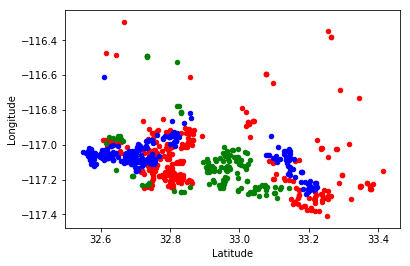

In [817]:
ax1 = zero.plot(kind='scatter', x='Latitude', y='Longitude', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='Latitude', y='Longitude', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='Latitude', y='Longitude', color='b', ax=ax1)    #two schools r blue

### Health Insur Covg % vs Mean Fam Income 

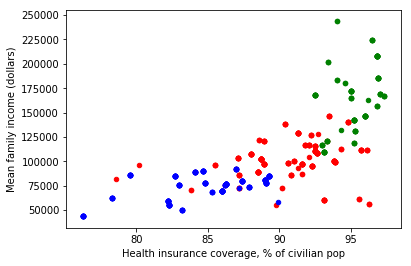

In [818]:
ax1 = zero.plot(kind='scatter', x='Health insurance coverage, % of civilian pop', y='Mean family income (dollars)', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='Health insurance coverage, % of civilian pop', y='Mean family income (dollars)', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='Health insurance coverage, % of civilian pop', y='Mean family income (dollars)', color='b', ax=ax1)    #two schools r blue

### Health Insur Covg % vs Abs Inc Standardized (covid cases inc)

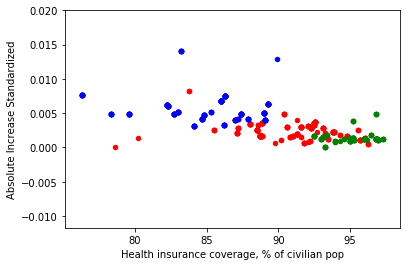

In [819]:
ax1 = zero.plot(kind='scatter', x='Health insurance coverage, % of civilian pop', y='Absolute Increase Standardized', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='Health insurance coverage, % of civilian pop', y='Absolute Increase Standardized', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='Health insurance coverage, % of civilian pop', y='Absolute Increase Standardized', color='b', ax=ax1)    #two schools r blue

### Mean fam income vs Abs Inc Standardized(covid cases increase)

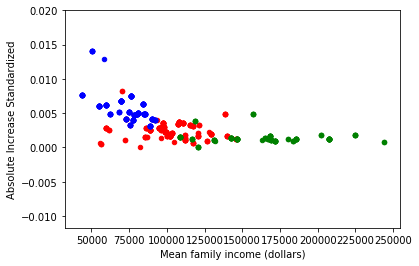

In [820]:
ax1 = zero.plot(kind='scatter', x='Mean family income (dollars)', y='Absolute Increase Standardized', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='Mean family income (dollars)', y='Absolute Increase Standardized', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='Mean family income (dollars)', y='Absolute Increase Standardized', color='b', ax=ax1)    #two schools r blue

In [821]:
print("0 mean Abs Inc Standardized: ", zero['Absolute Increase Standardized'].mean()* 100 ,' %')
print("1 mean Abs Inc Standardized: ", one['Absolute Increase Standardized'].mean() * 100 ,' %')
print("2 mean Abs Inc Standardized: ", two['Absolute Increase Standardized'].mean() * 100 ,' %')

0 mean Abs Inc Standardized:  0.25381574599974993  %
1 mean Abs Inc Standardized:  0.14377421909451032  %
2 mean Abs Inc Standardized:  0.5677662911255926  %


### Health Insur Covg % vs # of Cases of that zip

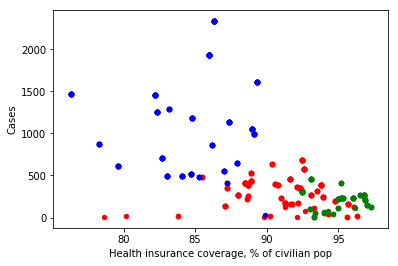

In [822]:
ax1 = zero.plot(kind='scatter', x='Health insurance coverage, % of civilian pop', y='Cases', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='Health insurance coverage, % of civilian pop', y='Cases', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='Health insurance coverage, % of civilian pop', y='Cases', color='b', ax=ax1)    #two schools r blue

### Worked at home vs # of Cases

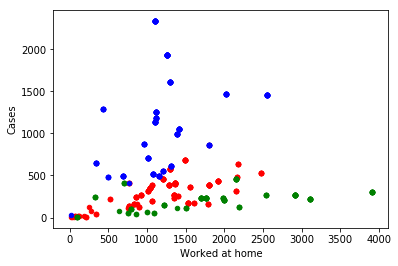

In [823]:
ax1 = zero.plot(kind='scatter', x='Worked at home', y='Cases', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='Worked at home', y='Cases', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='Worked at home', y='Cases', color='b', ax=ax1)    #two schools r blue

### Mean Fam income vs # of cases

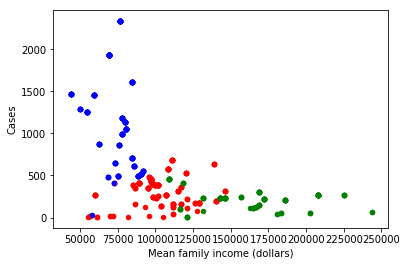

In [824]:
ax1 = zero.plot(kind='scatter', x='Mean family income (dollars)', y='Cases', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='Mean family income (dollars)', y='Cases', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='Mean family income (dollars)', y='Cases', color='b', ax=ax1)    #two schools r blue

### Cumulative Enrollment vs # of Cases

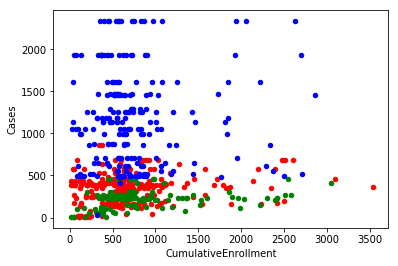

In [825]:
ax1 = zero.plot(kind='scatter', x='CumulativeEnrollment', y='Cases', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='CumulativeEnrollment', y='Cases', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='CumulativeEnrollment', y='Cases', color='b', ax=ax1)    #two schools r blue

In [826]:
print(len(two),len(zero),len(one))

222 266 130


### No Health Insurance pop vs # of cases

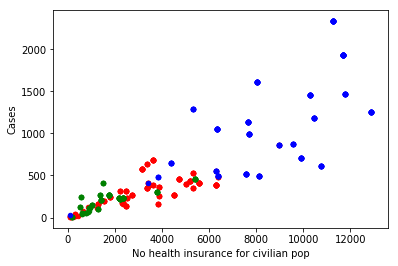

In [827]:
ax1 = zero.plot(kind='scatter', x='No health insurance for civilian pop', y='Cases', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='No health insurance for civilian pop', y='Cases', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='No health insurance for civilian pop', y='Cases', color='b', ax=ax1)    #two schools r blue

### Households with income 35,000-99,999 vs Population 16+

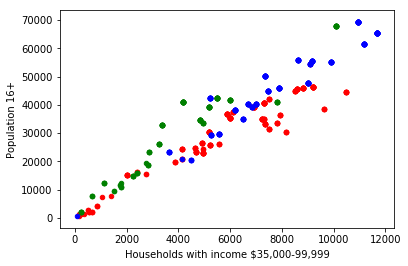

In [828]:
ax1 = zero.plot(kind='scatter', x='Households with income $35,000-99,999', y='Population 16+', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='Households with income $35,000-99,999', y='Population 16+', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='Households with income $35,000-99,999', y='Population 16+', color='b', ax=ax1)    #two schools r blue

# Visualizations AFTER Standardized features

### Health Insur Covg % vs Cases std

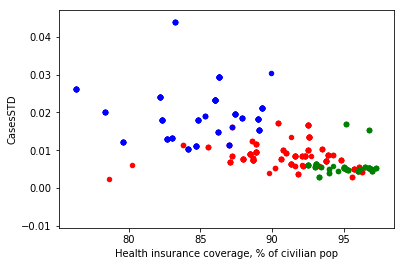

In [829]:
ax1 = zero.plot(kind='scatter', x='Health insurance coverage, % of civilian pop', y='CasesSTD', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='Health insurance coverage, % of civilian pop', y='CasesSTD', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='Health insurance coverage, % of civilian pop', y='CasesSTD', color='b', ax=ax1)    #two schools r blue

### Population Vs Cases

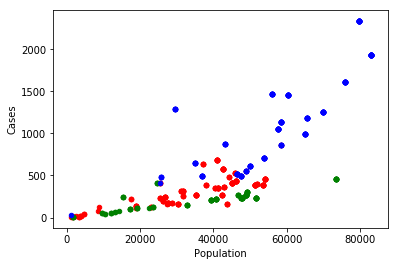

In [830]:
ax1 = zero.plot(kind='scatter', x='Population', y='Cases', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='Population', y='Cases', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='Population', y='Cases', color='b', ax=ax1)    #two schools r blue

### Worked At Home Standerdized vs Cases Standerdized

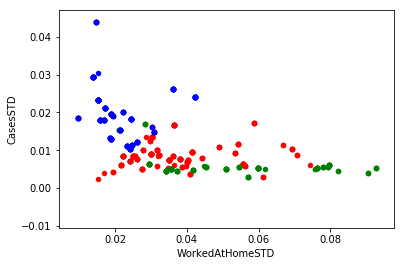

In [831]:
ax1 = zero.plot(kind='scatter', x='WorkedAtHomeSTD', y='CasesSTD', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='WorkedAtHomeSTD', y='CasesSTD', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='WorkedAtHomeSTD', y='CasesSTD', color='b', ax=ax1)    #two schools r blue

### HouseholdsIncome0kto35kSTD vs Cases Standerdized

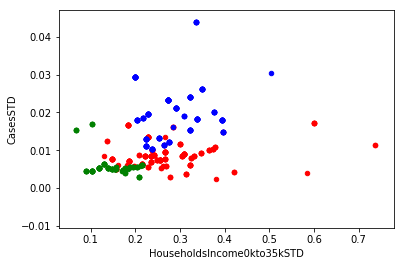

In [832]:
ax1 = zero.plot(kind='scatter', x='HouseholdsIncome0kto35kSTD', y='CasesSTD', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='HouseholdsIncome0kto35kSTD', y='CasesSTD', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='HouseholdsIncome0kto35kSTD', y='CasesSTD', color='b', ax=ax1)    #two schools r blue

### HouseholdsIncome35kto100kSTD vs Cases Standerdized

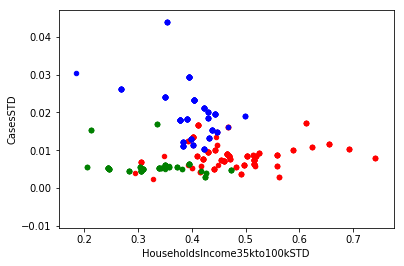

In [833]:
ax1 = zero.plot(kind='scatter', x='HouseholdsIncome35kto100kSTD', y='CasesSTD', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='HouseholdsIncome35kto100kSTD', y='CasesSTD', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='HouseholdsIncome35kto100kSTD', y='CasesSTD', color='b', ax=ax1)    #two schools r blue

### HouseholdsIncome100kPlusSTD vs Cases Standerdized

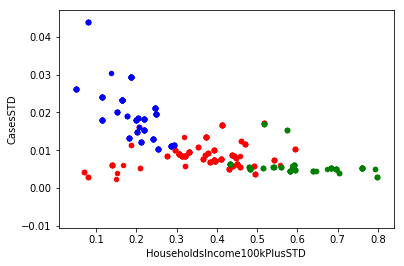

In [834]:
ax1 = zero.plot(kind='scatter', x='HouseholdsIncome100kPlusSTD', y='CasesSTD', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='HouseholdsIncome100kPlusSTD', y='CasesSTD', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='HouseholdsIncome100kPlusSTD', y='CasesSTD', color='b', ax=ax1)    #two schools r blue

### Children of the household 6-17 vs Cases Standerdized

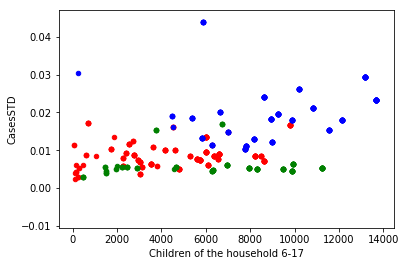

In [835]:
ax1 = zero.plot(kind='scatter', x='Children of the household 6-17', y='CasesSTD', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='Children of the household 6-17', y='CasesSTD', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='Children of the household 6-17', y='CasesSTD', color='b', ax=ax1)    #two schools r blue

### Mean family income (dollars) vs Cases Standerdized

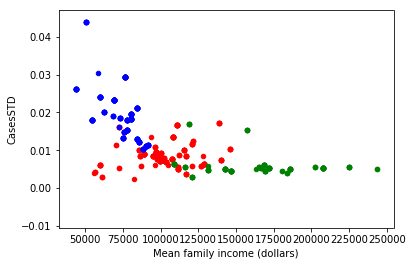

In [836]:
ax1 = zero.plot(kind='scatter', x='Mean family income (dollars)', y='CasesSTD', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='Mean family income (dollars)', y='CasesSTD', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='Mean family income (dollars)', y='CasesSTD', color='b', ax=ax1)    #two schools r blue

### Latino% vs Cases std

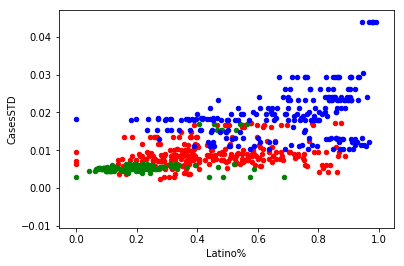

In [837]:
ax1 = zero.plot(kind='scatter', x='Latino%', y='CasesSTD', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='Latino%', y='CasesSTD', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='Latino%', y='CasesSTD', color='b', ax=ax1)    #two schools r blue

### CumulativeEnrollment vs Cases Std

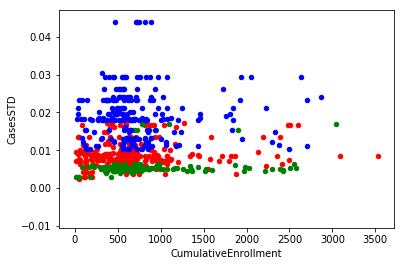

In [838]:
ax1 = zero.plot(kind='scatter', x='CumulativeEnrollment', y='CasesSTD', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='CumulativeEnrollment', y='CasesSTD', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='CumulativeEnrollment', y='CasesSTD', color='b', ax=ax1)    #two schools r blue

* red high
* blue mid
* green low

## Final CSV Formatting

In [839]:
# Finds mean # of enrolled students by type of school
done_shorter.groupby('EILName')['CumulativeEnrollment'].mean()

EILName
Elementary                          571.077114
Elementary-High Combination         431.142857
High School                        1279.233645
Intermediate/Middle/Junior High     881.863158
Name: CumulativeEnrollment, dtype: float64

In [840]:
# Create a bool col that determines if a school is highly populated or not based on type of school and mean # of enrollments
school_avg_enrollment = dict(done_shorter.groupby('EILName')['CumulativeEnrollment'].mean())
done_shorter['Mean Enrollment'] = done_shorter['EILName'].map(school_avg_enrollment)
done_shorter['Highly Populated'] = done_shorter['Mean Enrollment'] <= done_shorter['CumulativeEnrollment']

In [841]:
# Split Address col into seperate parts for easier front-end mapping
done_shorter['School'] = done_shorter['School, District'].apply(lambda x: x.split(',')[0])
done_shorter['Street'] = done_shorter['Address'].apply(lambda x: x.split(',')[0])
done_shorter['City'] = done_shorter['Address'].apply(lambda x: x.split(',')[1])
done_shorter.head(3)

,EILName,Latitude,Longitude,Address,Zipcode,"School, District",DistrictName,CumulativeEnrollment,Latino%,Median family income (dollars),...,HouseholdsIncome0kto35kSTD,HouseholdsIncome35kto100kSTD,HouseholdsIncome100kPlusSTD,CasesSTD,predictions,Mean Enrollment,Highly Populated,School,Street,City
0,High School,33.090580,-116.95009,"17701 San Pasqual Valley Road,Escondido,CA,92025",92025,"San Pasqual Academy, San Diego County Office o...",San Diego County Office of Education,94.0,0.436170,59509.0,...,0.27633,0.38406,0.211382,0.012185,2,1279.233645,False,San Pasqual Academy,17701 San Pasqual Valley Road,Escondido
1,Intermediate/Middle/Junior High,33.083711,-117.05634,"3003 Bear Valley Parkway,Escondido,CA,92025",92025,"Bear Valley Middle, Escondido Union",Escondido Union,1064.0,0.637218,59509.0,...,0.27633,0.38406,0.211382,0.012185,2,881.863158,True,Bear Valley Middle,3003 Bear Valley Parkway,Escondido
2,Elementary,33.118835,-117.07991,"122 West Fourth Avenue,Escondido,CA,92025",92025,"Central Elementary, Escondido Union",Escondido Union,649.0,0.927581,59509.0,...,0.27633,0.38406,0.211382,0.012185,2,571.077114,True,Central Elementary,122 West Fourth Avenue,Escondido


In [842]:
# done_shorter.to_csv(r'C:/Users/Andrew Chin/border_chlng/Datasets/done_shorter.csv')

## Feature Correlation Heat Map

In [843]:
corr = done_shorter.corr().drop(['Latitude','Longitude','No health insurance coverage %','Median family income (dollars)','Zipcode']).drop([
    'Latitude','Longitude','No health insurance coverage %','Median family income (dollars)','Zipcode'],axis = 1)

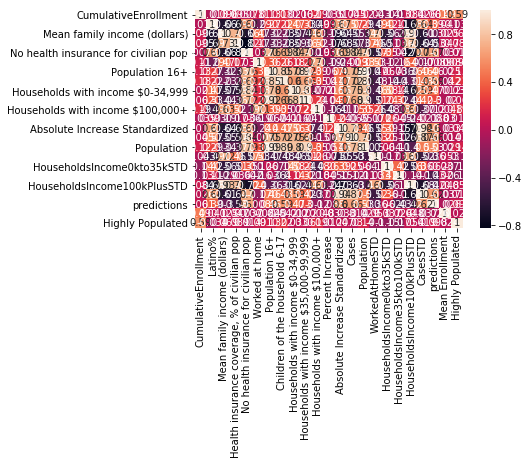

In [844]:
import seaborn as sns 
  
# generating correlation heatmap 
sns.heatmap(corr, annot = True) 